In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
import seaborn as sns

# default library imports

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
Weekly = load_data("Weekly")
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [3]:
df = Weekly.drop(columns = ["Direction"])

print(df.corr())

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000 -0.032289 -0.033390 -0.030006 -0.031128 -0.030519  0.841942   
Lag1   -0.032289  1.000000 -0.074853  0.058636 -0.071274 -0.008183 -0.064951   
Lag2   -0.033390 -0.074853  1.000000 -0.075721  0.058382 -0.072499 -0.085513   
Lag3   -0.030006  0.058636 -0.075721  1.000000 -0.075396  0.060657 -0.069288   
Lag4   -0.031128 -0.071274  0.058382 -0.075396  1.000000 -0.075675 -0.061075   
Lag5   -0.030519 -0.008183 -0.072499  0.060657 -0.075675  1.000000 -0.058517   
Volume  0.841942 -0.064951 -0.085513 -0.069288 -0.061075 -0.058517  1.000000   
Today  -0.032460 -0.075032  0.059167 -0.071244 -0.007826  0.011013 -0.033078   

           Today  
Year   -0.032460  
Lag1   -0.075032  
Lag2    0.059167  
Lag3   -0.071244  
Lag4   -0.007826  
Lag5    0.011013  
Volume -0.033078  
Today   1.000000  


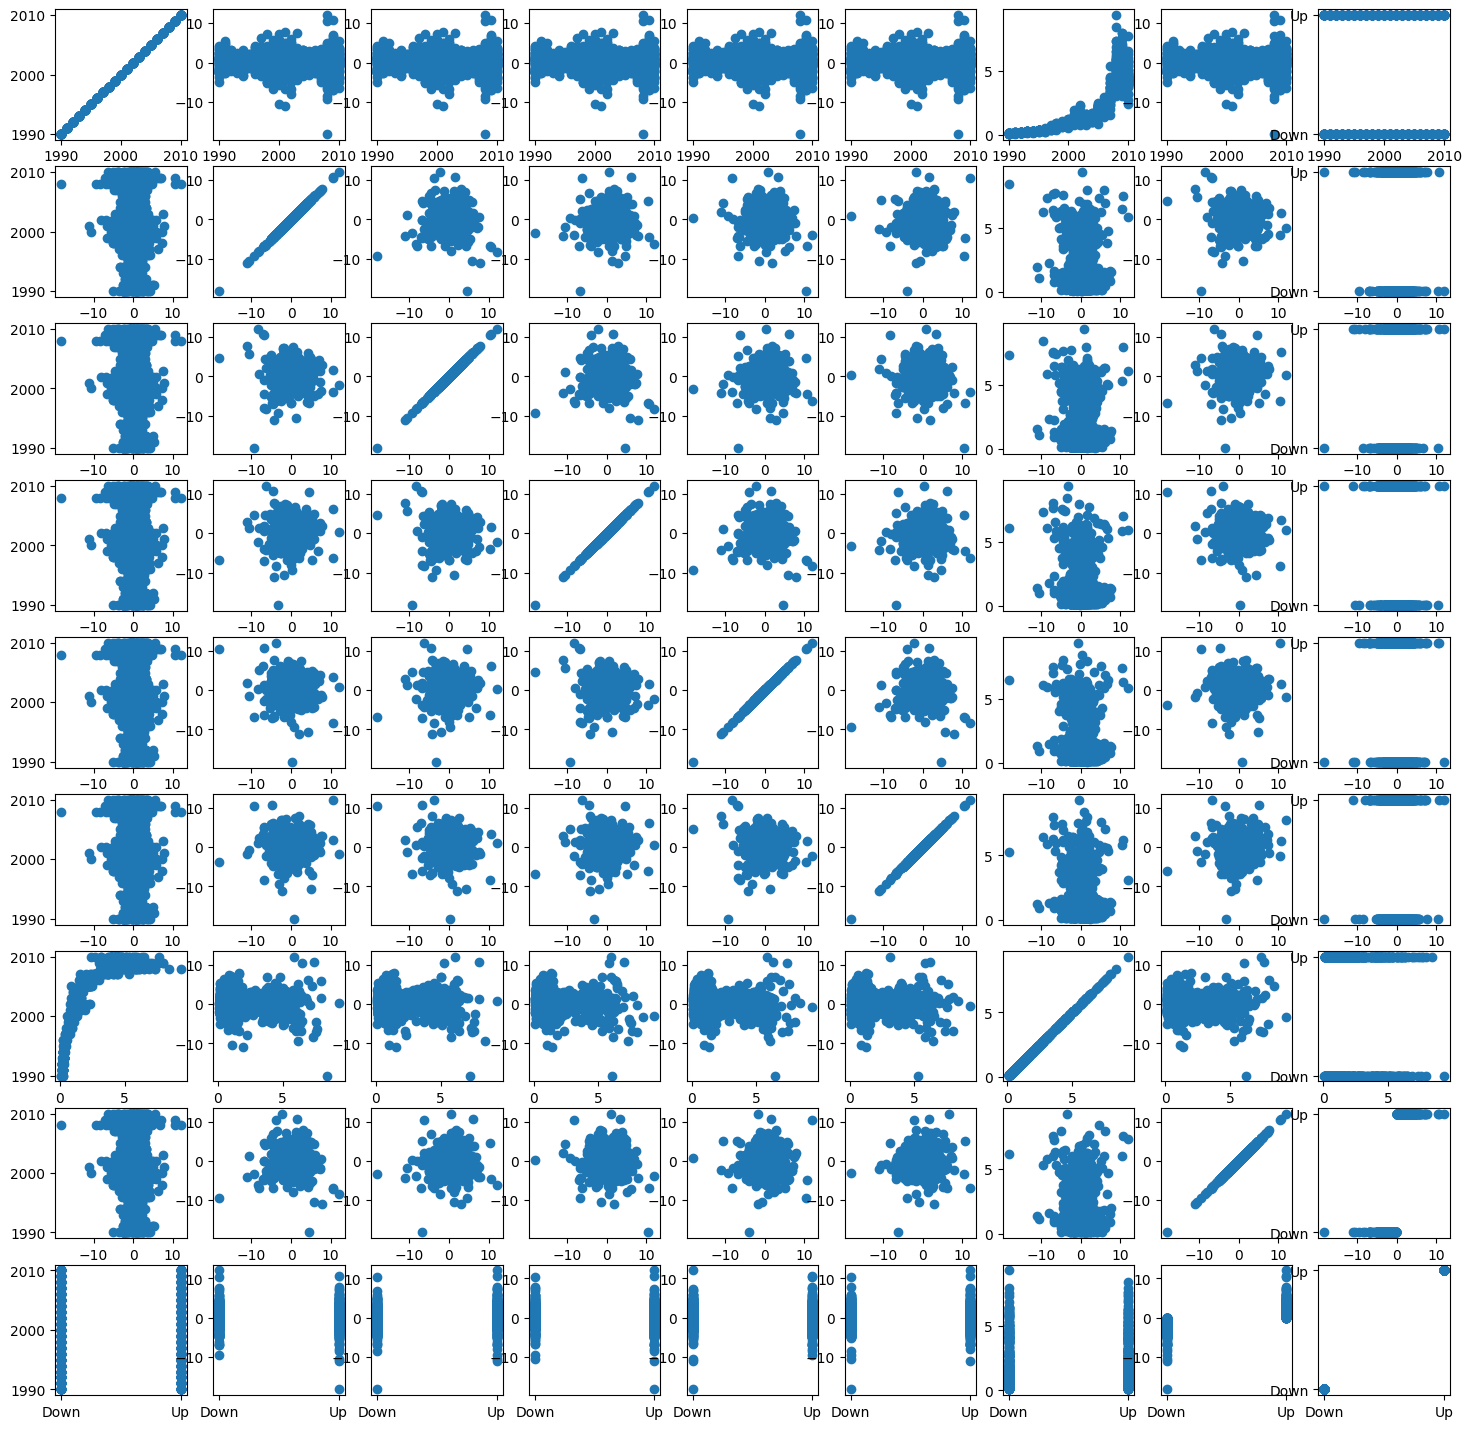

In [4]:
fig , ax = plt.subplots(9 , 9 , figsize = (18 , 18))
for i in range(9):
    for j in range(9):
        ax[i][j].scatter(Weekly[Weekly.columns[i]] , Weekly[Weekly.columns[j]])

- Based on the graph above, it appears that 'Years' and 'Volume' has a special correlation, a regression of some kind.
- Besides, Lags predictors have alike relations to each others

In [5]:

X = MS(Weekly.columns.drop(['Year' , 'Direction' , 'Today'])).fit_transform(Weekly)
y = Weekly['Direction'] == "Up"
logit = sm.GLM(y , X , family=sm.families.Binomial())

result = logit.fit()
summarize(result)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


- The intercept is the largest among all coefficents.

In [6]:
logit_pred = result.predict()
ans = np.array(['Down'] * logit_pred.shape[0])
ans[logit_pred > 0.5] = "Up"
confusion_table(ans , np.array(Weekly['Direction']))

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [7]:
np.mean(ans == np.array(Weekly['Direction']))

np.float64(0.5610651974288338)

- The logistic regression is making to much type-1-error (Truth = Down , Pred = Up)

In [8]:
train = np.array([False] * Weekly.shape[0])
X = MS(['Lag2']).fit_transform(Weekly)
y = Weekly.Direction == "Up"
train[Weekly.Year < 2008] = True

X_train = X.loc[train]
X_test = X.loc[~train]

y_train = y.loc[train]
y_test = Weekly.Direction.loc[~train]

X_train , y_train

(     intercept   Lag2
 0          1.0  1.572
 1          1.0  0.816
 2          1.0 -0.270
 3          1.0 -2.576
 4          1.0  3.514
 ..         ...    ...
 928        1.0 -1.237
 929        1.0  2.807
 930        1.0  1.588
 931        1.0 -2.440
 932        1.0  1.125
 
 [933 rows x 2 columns],
 0      False
 1      False
 2       True
 3       True
 4       True
        ...  
 928     True
 929    False
 930     True
 931    False
 932    False
 Name: Direction, Length: 933, dtype: bool)

In [9]:
glm_train = sm.GLM(y_train , X_train , family=sm.families.Binomial()) 
result = glm_train.fit()
summarize(result)

result_prob = result.predict(X_test)
labels = np.array(['Down'] * result_prob.shape[0])
labels[result_prob > 0.5] = 'Up'
confusion_table(labels , y_test)
# y_test , labels
# labels

Truth,Down,Up
Predicted,,
Down,7,5
Up,65,79


In [10]:
np.mean(labels == y_test)

np.float64(0.5512820512820513)

- The overall prediction accuracy is ~ 55.12%

In [11]:
lda = LDA(store_covariance=True)

In [12]:
train = np.array([False] * Weekly.shape[0])
X = MS(['Lag2']).fit_transform(Weekly)

y = Weekly.Direction == "Up"
train[Weekly.Year < 2008] = True

X_train = X.loc[train]
X_test = X.loc[~train]

y_train = Weekly.Direction.loc[train]
y_test = Weekly.Direction.loc[~train]

X_train = X_train.drop(columns = ["intercept"])
X_test = X_test.drop(columns = ["intercept"])


In [13]:
lda.fit(X_train , y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [39]:
lda_pred = lda.predict_proba(X_test)
labels = np.array(['Down'] * lda_pred.shape[0])
labels[lda_pred[: , 1] > 0.5] = 'Up'
# labels, lda_pred
confusion_table(labels , y_test)

Truth,Down,Up
Predicted,,
Down,6,5
Up,66,79


In [40]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred , y_test)

Truth,Down,Up
Predicted,,
Down,6,5
Up,66,79


In [44]:
np.mean(labels == y_test)

np.float64(0.5448717948717948)

- LDA predict accuracy ~ 54.48% which is way worse than Logistic Regression

In [17]:
qda = QDA(store_covariance=True)

In [18]:
qda.fit(X_train , y_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [19]:
qda_pred = qda.predict(X_test)
qda_pred

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'U

In [20]:
confusion_table(qda_pred , y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,72,84


In [21]:
np.mean(qda_pred == y_test)

np.float64(0.5384615384615384)

- QDA predicts it with 53.84% accuracy.

In [22]:
qda_pred = qda.predict_proba(X_test)
qda_pred[:,1]

array([0.51886704, 0.65377912, 0.51919405, 0.71363238, 0.52634871,
       0.74945144, 0.65850507, 0.55118146, 0.52372187, 0.5300524 ,
       0.56383138, 0.51886282, 0.63747728, 0.52139866, 0.70180516,
       0.56158151, 0.71008435, 0.5286348 , 0.54316987, 0.53325118,
       0.60652022, 0.59359205, 0.56479011, 0.56521585, 0.52071811,
       0.57616841, 0.57205452, 0.5228729 , 0.53421118, 0.56216928,
       0.51948219, 0.52335901, 0.61676199, 0.52265092, 0.51877075,
       0.51909246, 0.57897591, 0.53305595, 0.52425011, 0.58695808,
       0.94468244, 0.99998375, 0.72993196, 0.80972946, 0.98700532,
       0.61640962, 0.76928501, 0.90419575, 0.99631124, 0.54478823,
       0.5264962 , 0.53710419, 0.5307996 , 0.87387503, 0.64911013,
       0.65352527, 0.54147378, 0.51911031, 0.7708591 , 0.67233735,
       0.81558328, 0.65492353, 0.82664074, 0.9889985 , 0.55747815,
       0.83828078, 0.64009215, 0.56060202, 0.55521246, 0.51889858,
       0.54785582, 0.82040013, 0.68438718, 0.527324  , 0.66330

In [23]:
labels = np.array(["Down"] * X_test.shape[0])
labels[qda_pred[:,1] > 0.5] = "Up"
confusion_table(labels , y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,72,84


In [24]:
np.mean(labels == y_test)

np.float64(0.5384615384615384)

- QDA predicts it worse than just random guessing

In [25]:
knn = KNeighborsClassifier(n_neighbors=1)

In [26]:
train = np.array([False] * Weekly.shape[0])
X = MS(['Lag2']).fit_transform(Weekly)

y = Weekly.Direction == "Up"
train[Weekly.Year < 2008] = True

X_train = X.loc[train]
X_test = X.loc[~train]

y_train = Weekly.Direction.loc[train]
y_test = Weekly.Direction.loc[~train]

X_train = X_train.drop(columns = ["intercept"])
X_test = X_test.drop(columns = ["intercept"])


In [27]:
knn.fit(X_train , y_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred , y_test)

Truth,Down,Up
Predicted,,
Down,30,41
Up,42,43


In [28]:
np.mean(knn_pred == y_test)

np.float64(0.46794871794871795)

- KNN performance is so bad either, accuracy ~ 46,79%, which is worse than random guessing.

In [29]:
NB = GaussianNB()
NB.fit(X_train , y_train)

,priors,None
,var_smoothing,1e-09


In [34]:
nb_pred = NB.predict(X_test)
nb_pred

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'U

In [36]:
confusion_table(nb_pred , y_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,72,84


In [37]:
np.mean(nb_pred == y_test)

np.float64(0.5384615384615384)

- Based on the above results, we have the accuracy for each model:
    - LDA: 54.48%
    - QDA: 53.84%
    - KNN N = 1: 46.79%
    - NB: 53.84%

- Seeing those, we can conclude that LDA has the maximum accuracy.